---
# <div class="alert alert-info"> 1. Introduction </div>

This notebook covers fundamental analysis time series data analysis which include the following tasks:

2. Import relevant libraries
3. Get data
4. Preliminary Analysis
5. Perform statistical tests and analysis

---
# <div class="alert alert-info"> 2. Setup </div>

 ## <font color=red>2.1. Import library</font>

In [1]:
import quandl
import itertools
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import the libraries for time series analysis
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf,acf,pacf,ccovf,ccf,pacf_yw,pacf_ols
from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import mse, rmse, meanabs
from sklearn.model_selection import TimeSeriesSplit

 ## <font color=red>2.2. Configuration</font>

In [2]:
# Configuration
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# display various ranges 
pd.options.display.float_format = '{:.3f}'.format

# Supress warnings
import warnings
warnings.filterwarnings("ignore")

print("Setup complete...")

Setup complete...


---
# <div class="alert alert-info"> 3. Data Preparation
    
The analysis uses the International Airline Passengers dataset, which gives monthly totals in thousands of passengers  from January 1949 to December 1960.

 ## <font color=red>3.1.  Load data</font>

In [3]:
df = pd.read_csv('Data/airline_passengers.csv',index_col='Month',parse_dates=True)
df.dropna(inplace=True)
df_bk = df.copy()
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='Month', length=144, freq=None)

#### Setting a DatetimeIndex Frequency
Note that our DatetimeIndex does not have a frequency. In order to build a Holt-Winters smoothing model, statsmodels needs to know the frequency of the data (whether it's daily, monthly etc.). Since observations occur at the start of each month, we'll use MS.<br>A full list of time series offset aliases can be found <a href='http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases'>here</a>.

In [5]:
df.index.freq = 'MS'
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01', '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01', '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='Month', length=144, freq='MS')

---
# <div class="alert alert-info"> 4. Preliminary Analysis </div>

Time series analysis deals with understanding the underlying structure. Time series data can exhibit a huge variety of patterns and it's helpful to split a time series into several components, each representing one of the underlying categories of a pattern. Usually a time series can be segmented into four patterns: Trend, Seasonal, Cycles, Noise. A time series is comprised of the following three major components:

+ **Trend**: This is the increasing or decreasing behavior of the series with time. For example, population growth patterns. There are 3 types of trend: upward, down ward, horizontal/Stationary

+ **Seasonality**: Repeating trends. These are the periodic fluctuations in the observed data. For example, weather patterns or sale patterns

+ **Residual**: This is the remaining signal after removing the seasonality and trend signals. It can be further decomposed to remove the noise component as well

Analysizing time-series decomposition makes it easier to quickly identify a changing mean or variation in the data. These can be used to understand the structure of our time-series. The intuition behind time-series decomposition is important, as many forecasting methods build upon this concept of structured decomposition to produce forecasts

 ## <font color=red>4.1. Plot time series data</font>
 
 Graphs allow to visualize many features of the data, including patterns, unusual observations, changes over time, and relationships between variable

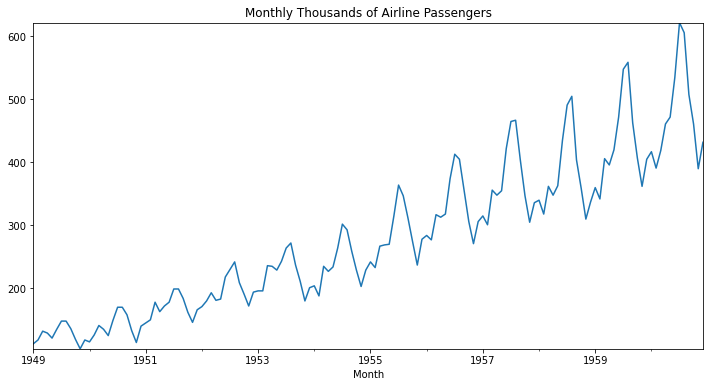

In [6]:
title = 'Monthly Thousands of Airline Passengers'
df['Thousands of Passengers'].plot(figsize=(12,6), title=title).autoscale(axis='both', tight=True)

The dataset shows the thousands of passengers flying per month from the years 1949 to late 1960.  The above plot clearly illustrates some of the fundamentals of time series analysis:

+ **trend**: There are two questions for the trend component: how is the trend going? Is it going in a straight linear upward curve or is it exponential? => On average, there's a general trend upward. There are two different types of trends: linear trend and exponential trend. This one looks like it could be slightly exponential.  
+ **seasonality**: We can see that based on the month of the year, there tends to be fluctuations that are repeating. notice that there’s peak travel during summer months because kids have summer vacations or people take their vacation when the weather is nice. And that’s where we get these sort of peaks and travel and we can all see repetitive peaks for holidays as well
+ **noise**: we also see random, non-systemic fluctuations in the data

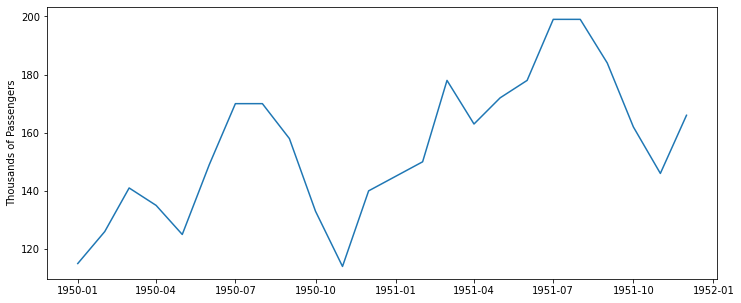

In [7]:
plt.figure(figsize=(12,5))
plt.plot(df.loc['1950':'1951', 'Thousands of Passengers'])
plt.ylabel('Thousands of Passengers')
plt.show()

 ## <font color=red> 4.2. Tools to separate out the different components
    
1. Hodrick-Prescott filter
2. ETS (Error-Trend-Seasonality) model

 ### <font color=blue> 1. Using Hodrick-Prescott filter to get the trend
    
The <a href='https://en.wikipedia.org/wiki/Hodrick%E2%80%93Prescott_filter'>Hodrick-Prescott filter</a> separates a time-series  $y_t$ into a trend component $\tau_t$ and a cyclical component $c_t$

$y_t = \tau_t + c_t$

The components are determined by minimizing the following quadratic loss function, where $\lambda$ is a smoothing parameter:

$\min_{\\{ \tau_{t}\\} }\sum_{t=1}^{T}c_{t}^{2}+\lambda\sum_{t=1}^{T}\left[\left(\tau_{t}-\tau_{t-1}\right)-\left(\tau_{t-1}-\tau_{t-2}\right)\right]^{2}$


The $\lambda$ value above handles variations in the growth rate of the trend component.<br>When analyzing quarterly data, the default lambda value of 1600 is recommended. Use 6.25 for annual data, and 129,600 for monthly data.

In [8]:
from statsmodels.tsa.filters.hp_filter import hpfilter

# tuple unpacking
passenger_cycle, passenger_trend = hpfilter(df['Thousands of Passengers'], lamb=129600)

In [9]:
df['trend'] = passenger_trend
df.head(6)

,Thousands of Passengers,trend
Month,,
1949-01-01,112,110.642
1949-02-01,118,112.572
1949-03-01,132,114.502
1949-04-01,129,116.432
1949-05-01,121,118.362
1949-06-01,135,120.293


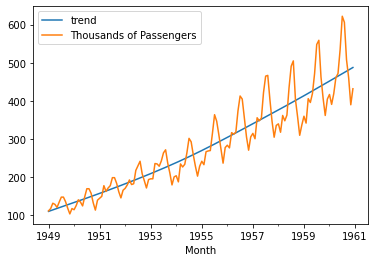

In [10]:
df[['trend', 'Thousands of Passengers']].plot().autoscale(axis='x')

 ### <font color=blue> 2. Decomposition plot: Error/Trend/Seasonality (ETS)

The <a href='https://en.wikipedia.org/wiki/Decomposition_of_time_series'>decomposition</a> of a time series attempts to isolate individual components such as <em>error</em>, <em>trend</em>, and <em>seasonality</em> (ETS).

Statsmodels provides a <em>seasonal decomposition</em> tool we can use to separate out the different components. This lets us see quickly and visually what each component contributes to the overall behavior.

We apply an <strong>additive</strong> model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. every year we add 10,000 passengers).<br>
A <strong>multiplicative</strong> model is more appropriate when we are increasing (or decreasing) at a non-linear rate (e.g. each year we double the amount of passengers).



 #### 'additive' model for linear trend

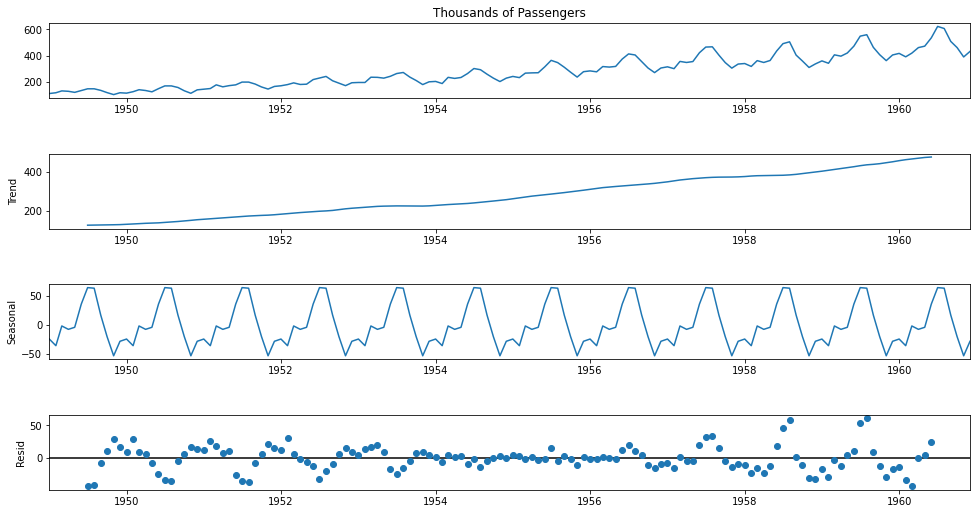

In [11]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(df['Thousands of Passengers'], model='additive')

# from matplotlib.pylab import rcParams
# rcParams['figure.figsize'] = 15,8
# decomposition.plot(),

fig = decomposition.plot()
fig.set_size_inches(15,8)

=> Interpretation:
   + At the very top is the original observed data. Then its decomposition is able to pull apart the trend, seasonal and residual or error.
   + The second plot show the trend which is the general growth pattern of the actual observed data points. So here we can see that it does look to have a general trend upwards and we can focus more on the trend components to see if it’s exponential or if it’s linear
   + Then the third plot is the isolated seasonal component, basically removing trend. And we can see here it looks like kind of perfectly repeating and that allows to analyze things based of seasonality
   + And then we have this residual component and this residual component is for things not explained by trend or seasonality. So any sort of residual or error that isn’t explained by the trend term or the seasonal term is going to be a residual. And that’s why the residual kind of almost looks like noise. But it can also be a good indicator of where there is noise in your data set and where your data set tends to be cleaner. So it looks like it’s a little noisier or a little slightly more residuals and errors at the beginning of our dataset than in the middle of our dataset

#### 'multiplicative' model for non-linear trend

Based on this chart, it looks like the trend in the earlier days is increasing at a higher rate than just linear (although it is a  bit hard to tell from this one plot).

<Figure size 432x288 with 0 Axes>

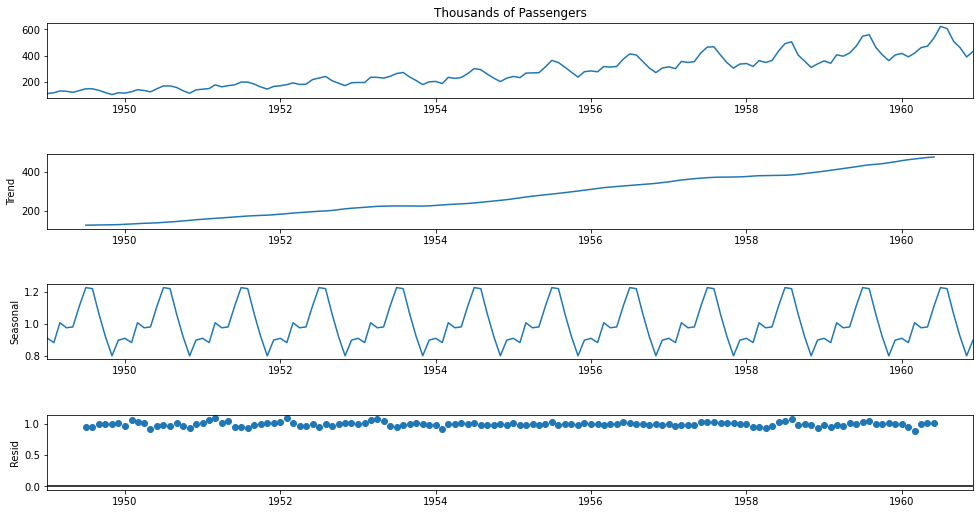

In [26]:
from statsmodels.tsa.seasonal  import seasonal_decompose

decomposition = seasonal_decompose(df['Thousands of Passengers'], model='multiplicative')
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [13]:
df['trend1'] = decomposition.trend
df.head(10)

,Thousands of Passengers,trend,trend1
Month,,,
1949-01-01,112,110.642,NaN
1949-02-01,118,112.572,NaN
1949-03-01,132,114.502,NaN
1949-04-01,129,116.432,NaN
1949-05-01,121,118.362,NaN
1949-06-01,135,120.293,NaN
1949-07-01,148,122.225,126.792
1949-08-01,148,124.158,127.250
1949-09-01,136,126.092,127.958


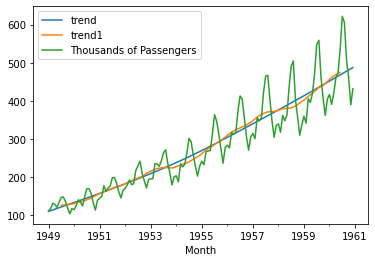

In [14]:
df[['trend', 'trend1',  'Thousands of Passengers']].plot().autoscale(axis='x')

In [15]:
decomposition.trend[0:10]

Month
1949-01-01       NaN
1949-02-01       NaN
1949-03-01       NaN
1949-04-01       NaN
1949-05-01       NaN
1949-06-01       NaN
1949-07-01   126.792
1949-08-01   127.250
1949-09-01   127.958
1949-10-01   128.583
Freq: MS, Name: trend, dtype: float64

In [16]:
decomposition.seasonal[0:10]

Month
1949-01-01   0.910
1949-02-01   0.884
1949-03-01   1.007
1949-04-01   0.976
1949-05-01   0.981
1949-06-01   1.113
1949-07-01   1.227
1949-08-01   1.220
1949-09-01   1.060
1949-10-01   0.922
Freq: MS, Name: seasonal, dtype: float64

In [17]:
decomposition.resid[0:10]

Month
1949-01-01     NaN
1949-02-01     NaN
1949-03-01     NaN
1949-04-01     NaN
1949-05-01     NaN
1949-06-01     NaN
1949-07-01   0.952
1949-08-01   0.953
1949-09-01   1.002
1949-10-01   1.004
Freq: MS, Name: resid, dtype: float64

---
# <div class="alert alert-info"> 5. Stationary </div>

## <font color=red> 5.1. Introduction

### <font color=blue> 1. Definition
Stationary refers to the property where for a time series its **means, variance and autocorrelation are time invariant**. In other words, mean, variance, and autocorrelation do not change with time. For instance, a time series having an upward (or downward) trend is clear indicator of a non-stationary because its mean would change in time. in the stationary case, the data evolves in time, but the distribution from which it is generated remains the same

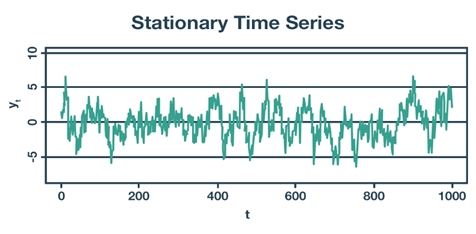
  
### <font color=blue>2. Comparison
    
**1. Mean needs to be constant**
    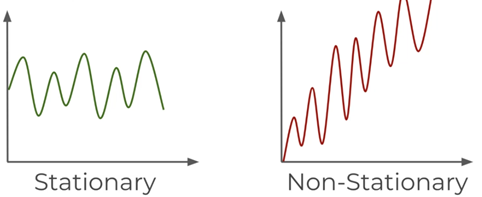
    
**2. Variance should not be a  function of time**
    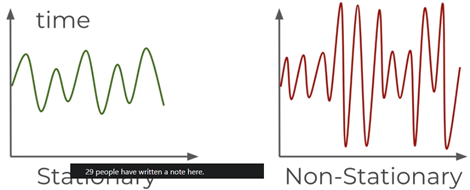
    
**3. Covariance should not e a function of time**    
    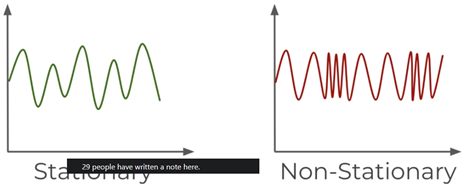
    
    
### <font color=blue>3.  Importance of Stationary
1. Why is stationarity one of the key components in time series analysis? First, because stationary processes are easier to analyze and model. The above informal definition also hints that such processes should be possible to predict, as the way they change is predictable.

2. What will happened if a process is not stationarity? While performing analysis, you would typically be interested in the expected value of the mean, the variance, etc. But if these parameters are continuously changing, estimating them by averaging over time will not be accurate. The inferences drawn from a non-stationarity process will not be reliable as its statistical properties will keep on changing with time.

3. Because of this, many statistical procedures applied in time series analysis makes an assumption that the underlying time series data is stationary. This assumption is necessary because most time series forecasting methods predict the statistical properties of the time series will remain the same in the future as they have been in the past

  

## <font color=red> 5.2. Example

The file <tt>samples.csv</tt> contains made-up datasets that illustrate stationary and non-stationary data.

In [18]:
df2 = pd.read_csv('Data/samples.csv', index_col=0, parse_dates=True)
df2.head()

,a,b,c,d
1950-01-01,36,27,0,67
1950-02-01,58,22,3,31
1950-03-01,61,17,5,67
1950-04-01,37,15,8,47
1950-05-01,66,13,8,62


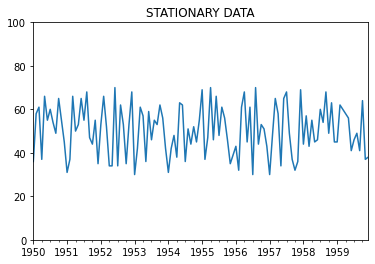

In [19]:
df2['a'].plot(ylim=[0,100],title="STATIONARY DATA").autoscale(axis='x',tight=True)

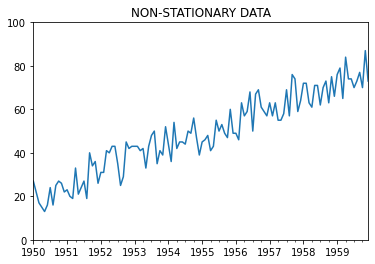

In [20]:
df2['b'].plot(ylim=[0,100],title="NON-STATIONARY DATA").autoscale(axis='x',tight=True)

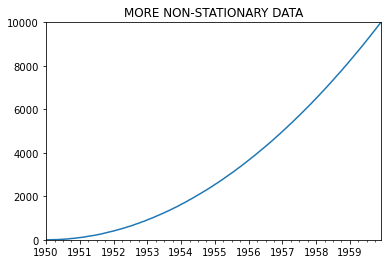

In [21]:
df2['c'].plot(ylim=[0,10000],title="MORE NON-STATIONARY DATA").autoscale(axis='x',tight=True)

## <font color=red> 5.3. Test for Stationary

There are two ways to check the stationarity of a time series:
   1. Plotting Rolling Statistics
   2. Dickey-Fuller Test

### <font color=blue> 1.  Plot the data along with a 12-month rolling mean and standared deviation

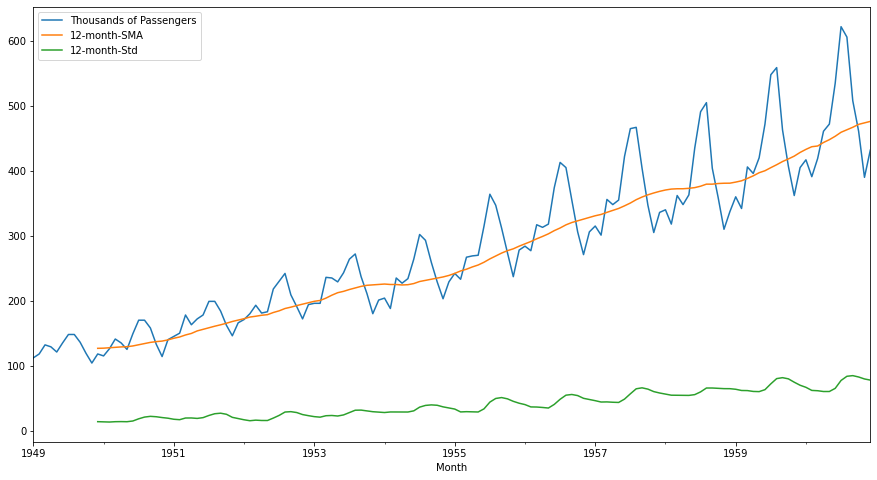

In [24]:
df['12-month-SMA'] = df['Thousands of Passengers'].rolling(window=12).mean()
df['12-month-Std'] = df['Thousands of Passengers'].rolling(window=12).std()

df[['Thousands of Passengers','12-month-SMA','12-month-Std']].plot(figsize=(15,8));

=> This time series has not only mean with a clear upward trend, the standard deviation increases over time as well => It is non-stationary data

### <font color=blue> 2. Augmented Dickey-Fuller Test
    
A test for stationarity usually involves a hypothesis test, where the null hypothesis $H_0$ is that the series is <em>nonstationary</em>, and contains a unit root. The alternate hypothesis $H_1$ supports stationarity.The test returns several statistics, a small p-value ($p<0.05$) indicates strong evidence against the null hypothesis.

#### Perform Augmented Dickey-Fuller Test

In [33]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df['Thousands of Passengers'],autolag='AIC')
dftest

(0.8153688792060463,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

To find out what these values represent we can run <tt>help(adfuller)</tt>. Then we can add our own labels:

In [31]:
print("Augmented Dickey-Fuller test on Airline data")
dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])
for key, val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)
if dftest[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller test on Airline data
ADF test statistic       0.815
p-value                  0.992
# lags used             13.000
# observations         130.000
critical value (1%)     -3.482
critical value (5%)     -2.884
critical value (10%)    -2.579
dtype: float64
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [35]:
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
for value,label in zip(dftest,labels):
    print(label + ' : ' + str(value))

Augmented Dickey-Fuller Test:
ADF Test Statistic : 0.8153688792060463
p-value : 0.991880243437641
#Lags Used : 13
Number of Observations Used : 130


**Function for running the augmented Dickey-Fuller test**

In [36]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

**Function to check stationary time series data**

In [37]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
def check_stationarity(timeseries, k):
    # Determing rolling statistics
    rolling_mean = timeseries.rolling(window=k, center=False).mean()
    rolling_std = timeseries.rolling(window = k, center = False).std()
        
    # Plot rolling statistics
    plt.figure(figsize=(16,7))
    plt.plot(timeseries.index.to_pydatetime(), timeseries.values, color ='blue', label = 'Original')
    plt.plot(rolling_mean.index.to_pydatetime(), rolling_mean.values, color='red', label='Rolling Mean')
    plt.plot(rolling_std.index.to_pydatetime(), rolling_std.values, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    adf_test(timeseries,title='')

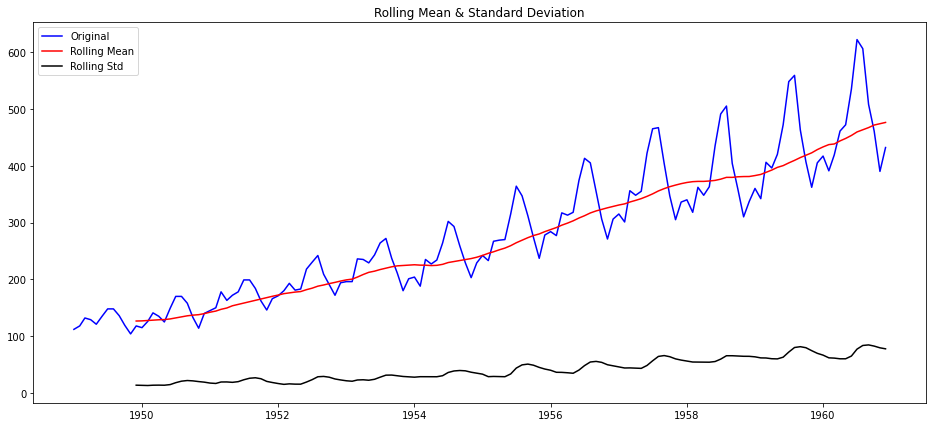

Augmented Dickey-Fuller Test: 
ADF test statistic       0.815
p-value                  0.992
# lags used             13.000
# observations         130.000
critical value (1%)     -3.482
critical value (5%)     -2.884
critical value (10%)    -2.579
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [38]:
check_stationarity(df['Thousands of Passengers'], 12)

---
# <div class="alert alert-info"> 6. Stationaries the time series </div>

In [39]:
df = df_bk.copy()

 ## <font color=red> 6.1.  Apply log transformation
    
Since it is quite evident that our original series data is non-stationary, we will perform a log transformation and see if we are able to obtain stationary

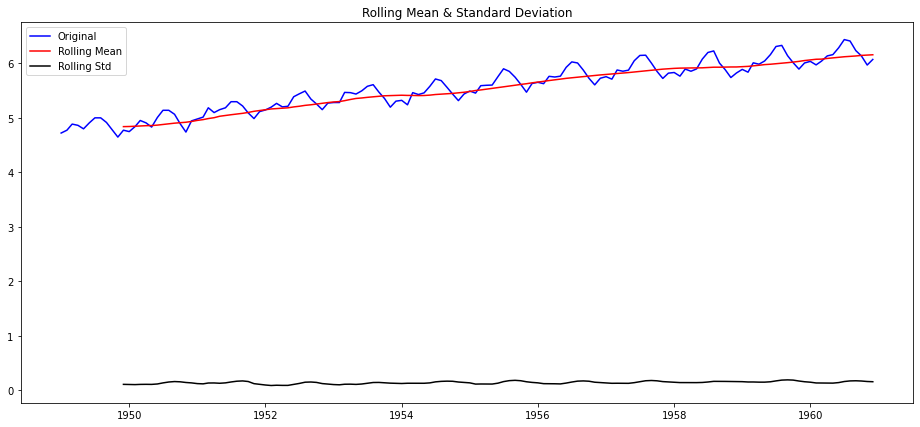

Augmented Dickey-Fuller Test: 
ADF test statistic      -1.717
p-value                  0.422
# lags used             13.000
# observations         130.000
critical value (1%)     -3.482
critical value (5%)     -2.884
critical value (10%)    -2.579
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [40]:
ts_data = df['Thousands of Passengers'].copy()
ts_data_log = np.log(ts_data)
check_stationarity(ts_data_log, 12)

=> The test statistic of 0.4 is greater than the critical values, hence we fail to reject the null hypothesis, i.e., the series is non-stationary even after log transformation. The output and plot confirm the same. The plot points out a time varying mean of the series and hence the non-stationarity. In order to achieve stationary the time series, we can apply an alternative approach which is differencing to the time series.

 ## <font color=red> 6.2. Differencing
    
Non-stationary data can be made to look stationary through <em>differencing</em> to remove trend and seasonality. Differencing is widely used to stabilize the mean of a time series. We simply compute difference between consecutive observations to obtain a different or not. We can also perform second order differencing, seasonal differencing and so on, depending on the time series at hand.

 ### <font color=blue> 1. Lagging
Also known as "backshifting", lagging notation reflects the value of $y$ at a prior point in time. This is a useful technique for performing <em>regressions</em> 

\begin{split}L{y_t} = y_{t-1} & \text{      one lag shifts the data back one period}\\
L^{2}{y_t} = y_{t-2} & \text{      two lags shift the data back two periods} \end{split}
<br><br>
<table>
<tr><td>$y_t$</td><td>6</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-1}$</td><td>8</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
<tr><td>$y_{t-2}$</td><td>3</td><td>4</td><td>9</td><td>2</td><td>5</td></tr>
</table>


 ### <font color=blue> 2.  First Order Differencing
    
A simple method called <em>first order differencing</em> calculates the difference between consecutive observations.

&nbsp;&nbsp;&nbsp;&nbsp;$y^{\prime}_t = y_t - y_{t-1}$

In this way a linear trend is transformed into a horizontal set of values.

#### sample data

In [43]:
# Calculate the first difference of the non-stationary dataset "b"
df2['d1b'] = df2['b'] - df2['b'].shift(1)
# An easier way to perform differencing on a pandas Series or DataFrame is to use the built-in diff() method
df2['d1b'] = df2['b'].diff()

df2[['b', 'd1b']].head()

,b,d1b
1950-01-01,27,NaN
1950-02-01,22,-5.000
1950-03-01,17,-5.000
1950-04-01,15,-2.000
1950-05-01,13,-2.000


Notice that differencing eliminates one or more rows of data from the beginning of the series.

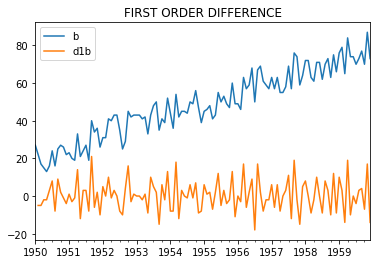

In [44]:
df2[['b','d1b']].plot(title="FIRST ORDER DIFFERENCE").autoscale(axis='x',tight=True);

#### Forecasting on first order differenced data
When forecasting with first order differences, the predicted values have to be added back in to the original values in order to obtain an appropriate forecast.

Let's say that the next five forecasted values after applying some model to <tt>df['d1b']</tt> are <tt>[7,-2,5,-1,12]</tt>. We need to perform an <em>inverse transformation</em> to obtain values in the scale of the original time series.

In [45]:
# For our example we need to build a forecast series from scratch
# First determine the most recent date in the training set, to know where the forecast set should start
df2[['b']].tail(3)

,b
1959-10-01,70
1959-11-01,87
1959-12-01,73


In [46]:
# Set a DateTime index for the forecast set that extends 5 periods into the future
idx = pd.date_range('1960-01-01', periods=5, freq='MS')
z = pd.DataFrame([7,-2,5,-1,12],index=idx,columns=['Fcast'])
z

,Fcast
1960-01-01,7
1960-02-01,-2
1960-03-01,5
1960-04-01,-1
1960-05-01,12


The idea behind an inverse transformation is to start with the most recent value from the training set, and to add a cumulative sum of Fcast values to build the new forecast set. For this we'll use the pandas <tt>.cumsum()</tt> function which does the reverse of <tt>.diff()</tt>

In [47]:
z['forecast'] = df2['b'].iloc[-1] + z['Fcast'].cumsum()
z

,Fcast,forecast
1960-01-01,7,80
1960-02-01,-2,78
1960-03-01,5,83
1960-04-01,-1,82
1960-05-01,12,94


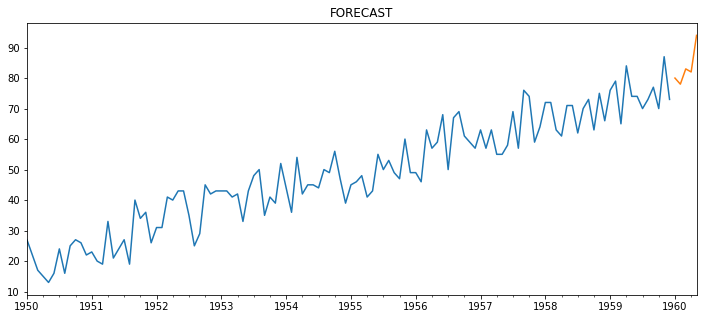

In [49]:
df2['b'].plot(figsize=(12,5), title="FORECAST").autoscale(axis='x',tight=True)

z['forecast'].plot();

#### Airline passengers data

<div class="alert alert-danger"><strong>NOTE:</strong> statsmodels has a built-in differencing tool:<br>
    
<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;from statsmodels.tsa.statespace.tools import diff<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;df2['d1'] = diff(df2['b'],k_diff=1)</font></tt><br><br>
    
that performs the same first order differencing operation shown above. We chose not to use it here because seasonal differencing is somewhat complicated. To difference based on 12 lags, the code would be<br><br>

<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;df2['d12'] = diff(df2['b'],k_diff=0,k_seasonal_diff=1,seasonal_periods=12)
</font></tt><br><br>

whereas with pandas it's simply<br><br>

<tt><font color=black>&nbsp;&nbsp;&nbsp;&nbsp;df2['d12'] = df2['b'].diff(12)
</font></tt>
</div>

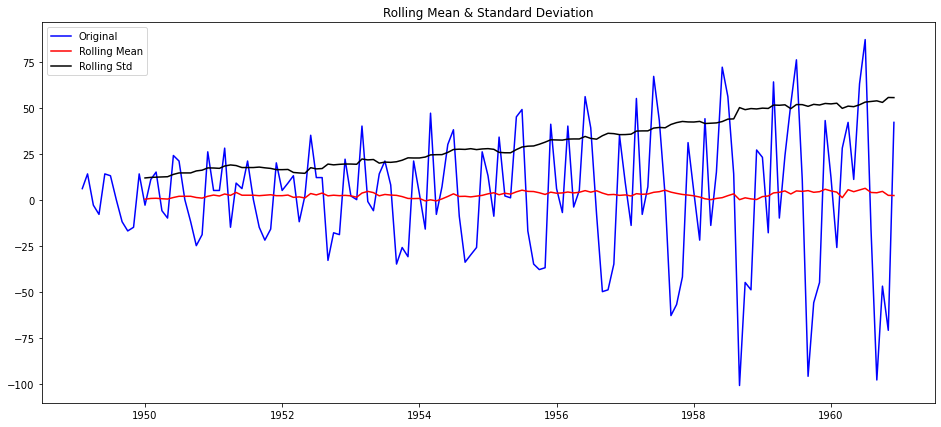

Augmented Dickey-Fuller Test: 
ADF test statistic      -2.829
p-value                  0.054
# lags used             12.000
# observations         130.000
critical value (1%)     -3.482
critical value (5%)     -2.884
critical value (10%)    -2.579
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [50]:
from statsmodels.tsa.statespace.tools import diff
df['d1'] = diff(df['Thousands of Passengers'], k_diff=1)
#df['d1'] = df['Thousands of Passengers'] - df['Thousands of Passengers'].shift(1)
#df['d1'] = df['Thousands of Passengers'].diff()

df['d1'].dropna(inplace=True)
#ts_data_diff = ts_data_diff[~np.isnan(ts_data_diff)]
check_stationarity(df['d1'],12)

 ### <font color=blue> 3. Second order differencing
Sometimes the first difference is not enough to attain stationarity, particularly if the trend is not linear. We can difference the already differenced values again to obtain a second order set of values.

&nbsp;&nbsp;&nbsp;&nbsp;$\begin{split}y_{t}^{\prime\prime} &= y_{t}^{\prime} - y_{t-1}^{\prime} \\
&= (y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) \\
&= y_t - 2y_{t-1} + y_{t-2}\end{split}$

#### sample data

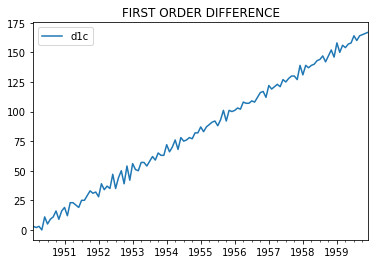

In [56]:
# First we'll look at the first order difference of dataset "c"
df2['d1c'] = df2['c'].diff()
df2[['d1c']].plot(title="FIRST ORDER DIFFERENCE").autoscale(axis='x',tight=True);

apply a second order difference to dataset "c".

<div class="alert alert-info"><strong>NOTE: </strong>This is different from <font color=black><tt>df2['c'].diff(2)</tt></font>, which would provide a first order difference spaced 2 lags apart.<br>
We'll use this technique later to address seasonality.</div>

In [55]:
# We can do this from the original time series in one step
df2['d2c'] = df2['c'].diff().diff()

df2[['c','d1c','d2c']].head()

,c,d1c,d2c
1950-01-01,0,NaN,NaN
1950-02-01,3,3.000,NaN
1950-03-01,5,2.000,-1.000
1950-04-01,8,3.000,1.000
1950-05-01,8,0.000,-3.000


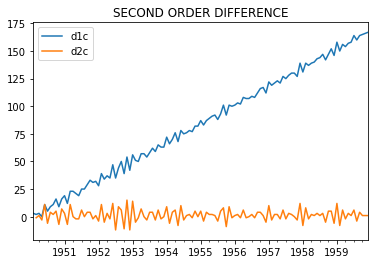

In [57]:
df2[['d1c','d2c']].plot(title="SECOND ORDER DIFFERENCE").autoscale(axis='x',tight=True);

#### Forecasting on second order differenced data
As before, the prediction values have to be added back in to obtain an appropriate forecast.

To invert the second order transformation and obtain forecasted values for $\hat y_t$ we have to solve the second order equation for $y_t$:

&nbsp;&nbsp;&nbsp;&nbsp;$\begin{split}y_{t}^{\prime\prime} &= y_t - 2y_{t-1} + y_{t-2} \\
y_t &= y_{t}^{\prime\prime} + 2y_{t-1} - y_{t-2}\end{split}$

Let's say that the next five forecasted values after applying some model to <tt>df['d2c']</tt> are <tt>[7,-2,5,-1,12]</tt>.

In [59]:
# For our example we need to build a forecast series from scratch
idx = pd.date_range('1960-01-01', periods=5, freq='MS')
z = pd.DataFrame([7,-2,5,-1,12],index=idx,columns=['Fcast'])

One way to invert a 2nd order transformation is to follow the formula above:

In [60]:
forecast = []

# Capture the two most recent values from the training set
v2,v1 = df2['c'].iloc[-2:]

# Apply the formula
for i in z['Fcast']:
    newval = i + 2*v1 - v2
    forecast.append(newval)
    v2,v1 = v1,newval

z['forecast']=forecast
z

,Fcast,forecast
1960-01-01,7,10174
1960-02-01,-2,10346
1960-03-01,5,10523
1960-04-01,-1,10699
1960-05-01,12,10887


Another, perhaps more straightforward method is to create a first difference set from the second, then build the forecast set from the first difference. We'll again use the pandas <tt>.cumsum()</tt> function which does the reverse of <tt>.diff()</tt>

In [61]:
# Add the most recent first difference from the training set to the Fcast cumulative sum
z['firstdiff'] = (df2['c'].iloc[-1]-df2['c'].iloc[-2]) + z['Fcast'].cumsum()

# Now build the forecast values from the first difference set
z['forecast'] = df2['c'].iloc[-1] + z['firstdiff'].cumsum()

z[['Fcast','firstdiff','forecast']]

,Fcast,firstdiff,forecast
1960-01-01,7,174,10174
1960-02-01,-2,172,10346
1960-03-01,5,177,10523
1960-04-01,-1,176,10699
1960-05-01,12,188,10887


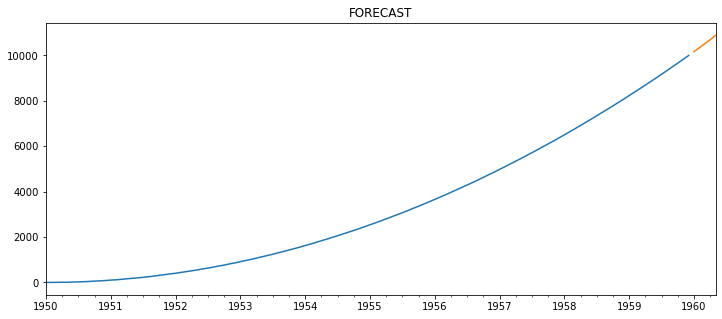

In [62]:
df2['c'].plot(figsize=(12,5), title="FORECAST").autoscale(axis='x',tight=True)

z['forecast'].plot();

#### Airline passengers ds

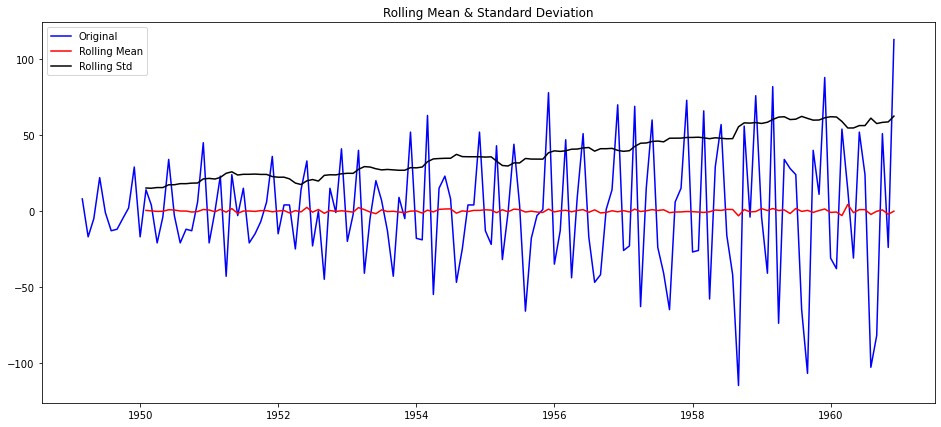

Augmented Dickey-Fuller Test: 
ADF test statistic     -16.384
p-value                  0.000
# lags used             11.000
# observations         130.000
critical value (1%)     -3.482
critical value (5%)     -2.884
critical value (10%)    -2.579
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [63]:
# First we'll look at the first order difference of dataset "c"
df['d2'] = df['Thousands of Passengers'].diff().diff()
df['d2'].dropna(inplace=True)
#ts_data_diff = ts_data_diff[~np.isnan(ts_data_diff)]
check_stationarity(df['d2'],12)

 ### <font color=blue> 4. Seasonal Difference

**Seasonal Difference**

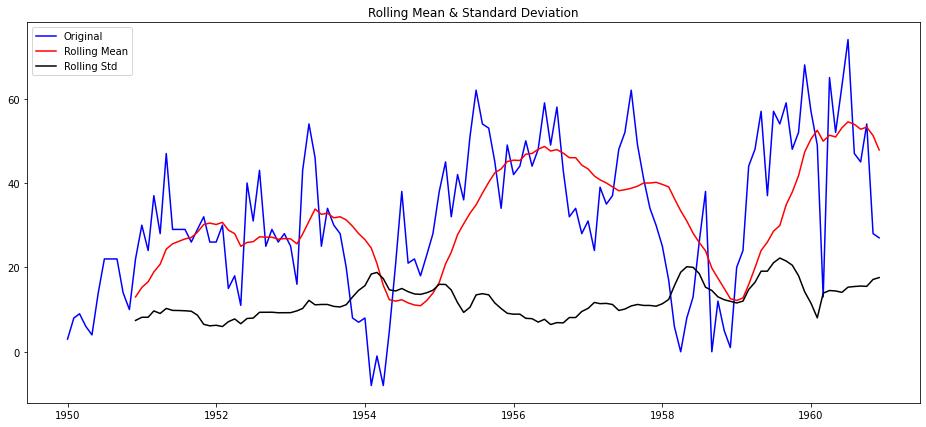

Augmented Dickey-Fuller Test: 
ADF test statistic      -3.383
p-value                  0.012
# lags used              1.000
# observations         130.000
critical value (1%)     -3.482
critical value (5%)     -2.884
critical value (10%)    -2.579
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [64]:
df['s'] = df['Thousands of Passengers'] - df['Thousands of Passengers'].shift(12)
check_stationarity(df['s'].dropna(),12)

**Seasonal First order Difference**

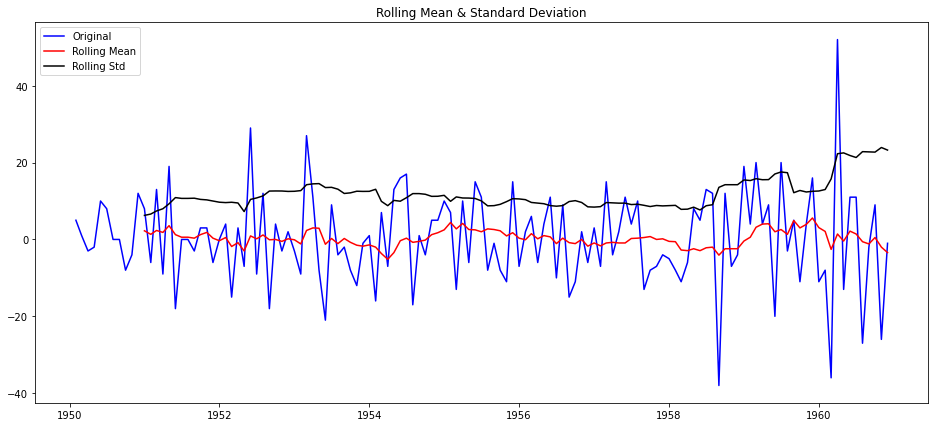

Augmented Dickey-Fuller Test: 
ADF test statistic     -15.596
p-value                  0.000
# lags used              0.000
# observations         130.000
critical value (1%)     -3.482
critical value (5%)     -2.884
critical value (10%)    -2.579
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [65]:
# You can also do seasonal first difference
df['s1'] = df['d1'] - df['d1'].shift(12)
check_stationarity(df['s1'].dropna(),12)

---
# <div class="alert alert-info"> 7. Autocorrelation and Partial Autocorrelation </div>

In [66]:
df = df_bk.copy()

# Load a stationary dataset
df2 = pd.read_csv('Data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

## <font color=red> 7.1. Autocorrelation

With a time series, $x$ is a fixed interval. Here we want to look at the variance of $y_t$ against lagged or shifted values of $y_{t+k}$
    
For a stationary time series, the autocovariance function for $\gamma$ (gamma) is given as:

${\displaystyle {\gamma}_{XX}(t_{1},t_{2})=\operatorname {Cov} \left[X_{t_{1}},X_{t_{2}}\right]=\operatorname {E} [(X_{t_{1}}-\mu _{t_{1}})(X_{t_{2}}-\mu _{t_{2}})]}$

We can calculate a specific $\gamma_k$ with:

${\displaystyle \gamma_k = \frac 1 n \sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})}$

**Example**: 
We have a time series with five observations: {13, 5, 11, 12, 9}  <br>
=> We can calculate that $n = 5$, the mean $\bar{y} = 10$, the variance $\sigma^2 = 8$ <br>
The following calculations gives us our covariance values:
<br><br>
$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} 5 = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} 5 = \frac {-20} 5 = -4.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} 5 = \frac {-8} 5 = -1.6 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} 5 = \frac {11} 5 = 2.2 \\
\gamma_4 = \frac {(13-10)(9-10)} 5 = \frac {-3} 5 = -0.6$
<br><br>
Note that $\gamma_0$ is just the population variance $\sigma^2$

Let's see if statsmodels gives us the same results! For this we'll create a <strong>fake</strong> dataset:

In [68]:
ts = pd.DataFrame({'a': [13, 5, 11, 12, 9]})
arr = acovf(ts['a'])
arr

array([ 8. , -4. , -1.6,  2.2, -0.6])

**Unbiased Autocovariance**

Note that the number of terms in the calculations above are decreasing
Statsmodels can return an "unbiased" autocovariance where instead of dividing by $n$ we divide by $n-k$

$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} {5-0} = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} {5-1} = \frac {-20} 4 = -5.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} {5-2} = \frac {-8} 3 = -2.67 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} {5-3} = \frac {11} 2 = 5.5 \\
\gamma_4 = \frac {(13-10)(9-10)} {5-4} = \frac {-3} 1 = -3.0$

In [69]:
arr2 = acovf(ts['a'], unbiased=True)
arr2

array([ 8.        , -5.        , -2.66666667,  5.5       , -3.        ])

**Autocorrelation for 1D**
The correlation $\rho$ (rho) between two variables $y_1,y_2$ is given as:

### $\rho = \frac {\operatorname E[(y_1−\mu_1)(y_2−\mu_2)]} {\sigma_{1}\sigma_{2}} = \frac {\operatorname {Cov} (y_1,y_2)} {\sigma_{1}\sigma_{2}}$,

where $E$ is the expectation operator, $\mu_{1},\sigma_{1}$ and $\mu_{2},\sigma_{2}$ are the means and standard deviations of $y_1$ and $y_2$.

When working with a single variable (i.e. <em>autocorrelation</em>) we would consider $y_1$ to be the original series and $y_2$ a lagged version of it. Note that with autocorrelation we work with $\bar y$, that is, the full population mean, and <em>not</em> the means of the reduced set of lagged factors (see note below).

Thus, the formula for $\rho_k$ for a time series at lag $k$ is:

${\displaystyle \rho_k = \frac {\sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})} {\sum\limits_{t=1}^{n} (y_t - \bar{y})^2}}$

This can be written in terms of the covariance constant $\gamma_k$ as:

${\displaystyle \rho_k = \frac {\gamma_k n} {\gamma_0 n} = \frac {\gamma_k} {\sigma^2}}$

For example,<br>
$\rho_4 = \frac {\gamma_4} {\sigma^2} = \frac{-0.6} {8} = -0.075$

Note that ACF values are bound by -1 and 1. That is, ${\displaystyle -1 \leq \rho_k \leq 1}$

In [70]:
arr3 = acf(ts['a'])
arr3

array([ 1.   , -0.5  , -0.2  ,  0.275, -0.075])

#### A note about AutoCorrelation

    Some texts compute lagged correlations using the Pearson Correlation Coefficient given by:<br><br>
${\displaystyle r_{xy}={\frac {\sum _{i=1}^{n}(x_{i}-{\bar {x}})(y_{i}-{\bar {y}})}{{\sqrt {\sum _{i=1}^{n}(x_{i}-{\bar {x}})^{2}}}{\sqrt {\sum _{i=1}^{n}(y_{i}-{\bar {y}})^{2}}}}}}$

These are easily calculated in numpy with <tt>numpy.corrcoef(x,y)</tt> and in Excel with <tt>=CORREL(x,y)</tt>.<br><br>
Using our example, $r_0$ is still $1$, but to solve for $r_1$:

${\displaystyle x_1 = [13, 5, 11, 12], \bar{x_1} = 10.25}$<br><br>
$y_1 = [5, 11, 12, 9],\  \bar{y_1} = 9.25$<br><br>
$r_{{x_1}{y_1}}=\frac {(13-10.25)(5-9.25)+(5-10.25)(11-9.25)+(11-10.25)(12-9.25)+(12-10.25)(9-9.25)}
{\sqrt{((13-10.25)^2+(5-10.25)^2+(11-10.25)^2+(12-10.25)^2)}\sqrt{((5-9.25)^2+(11-9.25)^2+(12-9.25)^2+(9-9.25)^2)}} = \frac {-19.25} {33.38} = -0.577$
<br><br>
However, there are some shortcomings. Using the Pearson method, the second-to-last term $r_{k-1}$ will always be $1$ and the last term $r_k$ will always be undefined.
</div>

## <font color=red> 7.2. Partial Autocorrelation
    
Partial autocorrelations measure the linear dependence of one variable after removing the effect of other varibale(s) that affect both variales. That is, the partial autocorrelation at lag k is the autocorrelation between $y_t$ and $y_t+k$ that is not accountedd for by lags $1$ through $k-1$ 
    
A common method employs the non-recursive <a href='https://en.wikipedia.org/wiki/Autoregressive_model#Calculation_of_the_AR_parameters'>Yule-Walker Equations</a>:

$\phi_0 = 1\\
\phi_1 = \rho_1 = -0.50\\
\phi_2 = \frac {\rho_2 - {\rho_1}^2} {1-{\rho_1}^2} = \frac {(-0.20) - {(-0.50)}^2} {1-{(-0.50)}^2}= \frac {-0.45} {0.75} = -0.60$

As $k$ increases, we can solve for $\phi_k$ using matrix algebra and the <a href='https://en.wikipedia.org/wiki/Levinson_recursion'>Levinson–Durbin recursion</a> algorithm which maps the sample autocorrelations $\rho$ to a <a href='https://en.wikipedia.org/wiki/Toeplitz_matrix'>Toeplitz</a> diagonal-constant matrix. The full solution is beyond the scope of this course, but the setup is as follows:


$\displaystyle \begin{pmatrix}\rho_0&\rho_1&\cdots &\rho_{k-1}\\
\rho_1&\rho_0&\cdots &\rho_{k-2}\\
\vdots &\vdots &\ddots &\vdots \\
\rho_{k-1}&\rho_{k-2}&\cdots &\rho_0\\
\end{pmatrix}\quad \begin{pmatrix}\phi_{k1}\\\phi_{k2}\\\vdots\\\phi_{kk}\end{pmatrix}
\mathbf = \begin{pmatrix}\rho_1\\\rho_2\\\vdots\\\rho_k\end{pmatrix}$

In [71]:
arr4 = pacf_yw(ts['a'], nlags=4, method='mle')
arr4

array([ 1.        , -0.5       , -0.6       , -0.38541667, -0.40563273])

<div class="alert alert-info"><strong>NOTE:</strong> We passed in <tt><font color=black>method='mle'</font></tt> above in order to use biased ACF coefficients. "mle" stands for "maximum likelihood estimation". Alternatively we can pass <tt>method='unbiased'</tt> (the statsmodels default):</div>

In [72]:
arr5 = pacf_yw(ts['a'],nlags=4,method='adjusted')
arr5

array([ 1.        , -0.625     , -1.18803419,  2.03764205,  0.8949589 ])

**Partial Autocorrelation with OLS**
This provides partial autocorrelations with <a href='https://en.wikipedia.org/wiki/Ordinary_least_squares'>ordinary least squares</a> (OLS) estimates for each lag instead of Yule-Walker.

In [73]:
arr6 = pacf_ols(ts['a'], nlags=4)
arr6

array([ 1.        , -0.49677419, -0.43181818,  0.53082621,  0.25434783])

## <font color=red> 7.3. Plotting

In [74]:
df['d2'] = df['Thousands of Passengers'].diff().diff()

### <font color=blue> 1.  Lag plot
Pandas has a built-in plotting function that plots increasing $y_t$ values on the horizontal axis against lagged versions of the values $y_{t+1}$ on the vertical axis. If a dataset is non-stationary with an upward trend, then neighboring values should trend in the same way. Let's look at the <strong>Airline Passengers</strong> dataset first.

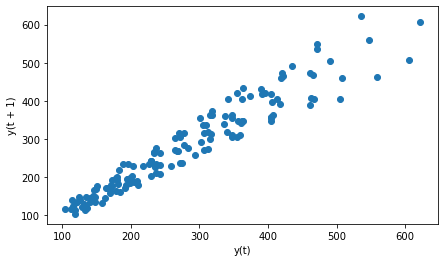

In [75]:
from pandas.plotting import lag_plot

plt.figure(figsize = (7,4))
lag_plot(df['Thousands of Passengers']);

Visually this shows evidence a very strong autocorrelation; as $y_t$ values increases, nearby (lagged) values also increase

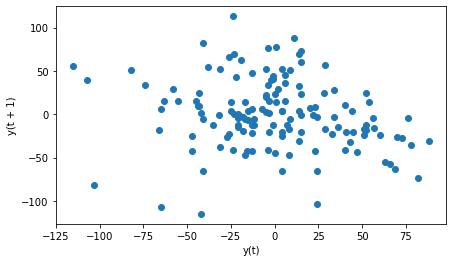

In [76]:
plt.figure(figsize = (7,4))
lag_plot(df['d2']);

As expected, there is little evidence of autocorrelation here.

### <font color=blue> 2.  ACF (Auto Correlation Function) plot
    
The ACF plot helps us understand the **correlation of an observation with its lag (or previous value)**. 
       
The ACF and PACF plot also helps us understand if a series is stationary or not. If a series has gradualy decreasing values for ACF and PACF, it points toward non-stationary property in the series. 
    
The ACF plot is also used to determine the MA order, i.e., q. The value at which ACF drops is the order of the MA model

#### ACF of original data  (non-stationary)

In [77]:
acf(df['Thousands of Passengers'])

array([1.        , 0.94804734, 0.87557484, 0.80668116, 0.75262542,
       0.71376997, 0.6817336 , 0.66290439, 0.65561048, 0.67094833,
       0.70271992, 0.74324019, 0.76039504, 0.71266087, 0.64634228,
       0.58592342, 0.53795519, 0.49974753, 0.46873401, 0.44987066,
       0.4416288 , 0.45722376])

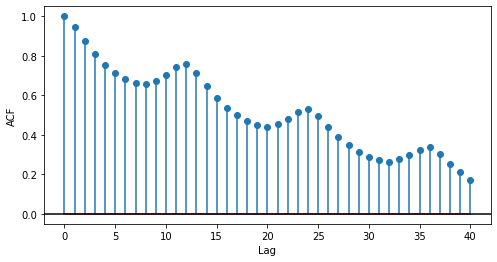

In [78]:
from statsmodels.tsa.stattools import acf
lac_acf = acf(df['Thousands of Passengers'], nlags=40)
plt.figure(figsize=(8,4))
plt.stem(lac_acf)
plt.axhline(y=0, linestyle='-', color='black')
plt.xlabel('Lag')
plt.ylabel('ACF');

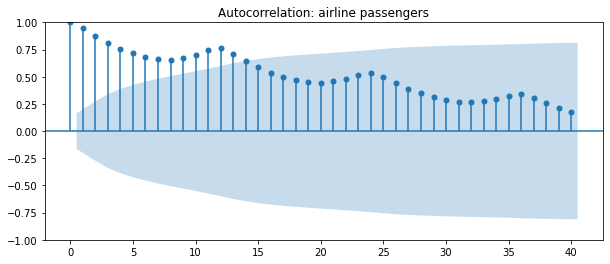

In [80]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# Plot autocorrelation at different  lags
fig, ax = plt.subplots(figsize=(10,4))
lags = 40
title = 'Autocorrelation: airline passengers'
plot_acf(df['Thousands of Passengers'],ax=ax, title=title, lags=lags);

=> Interpretation:
   + All correlograms start at 1; this is because when t = 0, we are comparing the time series with itself
   + We can see that the time series is not random, but rather has a high degree of autocorrelation of adjacent and near-adjacent observations
   + This plot indicates non-stationary data, as there are a large number of lags before ACF values drop off. The ACF for lag 1 in the first plot is very high, close to one and it decreases very slowly. This is the case of a non-stationary series.

#### ACF of second order differencing (stationary data)

In [81]:
acf(df['d2'].dropna())

array([ 1.        , -0.19100587, -0.19598169, -0.0485473 , -0.20664662,
        0.11939696,  0.02575129,  0.14558204, -0.22613908,  0.01407533,
       -0.2082756 , -0.12089977,  0.78224898, -0.09592873, -0.19547382,
       -0.07034343, -0.14794844,  0.11319557,  0.01921939,  0.13695131,
       -0.24015233,  0.02613065])

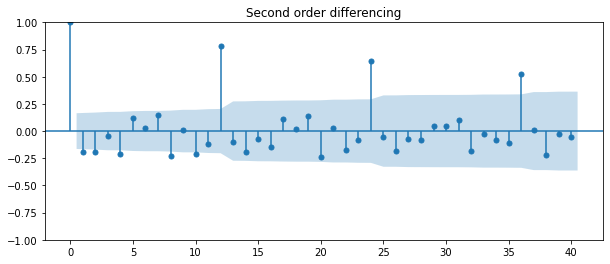

In [82]:
# Plot autocorrelation at different  lags
fig, ax = plt.subplots(figsize=(10,4))
lags = 40
title = 'Second order differencing'
plot_acf(df['d2'].dropna(),ax=ax, title=title, lags=lags);

This is a typical ACF plot for stationary data, with lags on the horizontal axis and correlations on the vertical axis. The first value $y_0$ is always 1. A sharp dropoff indicates that there is no AR component in the ARIMA model.

### <font color=blue> 3. PACF plot 
    
PACF points toward **correlation between an observation and a specific lagged value, excluding effect of other lags**. The value at which PACF drops points toward the order of AR model or the p in ARIMA(p,d,q)

#### ACF of original data  (non-stationary)

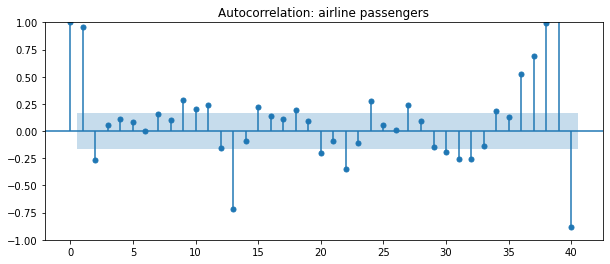

In [83]:
# Plot autocorrelation at different  lags
fig, ax = plt.subplots(figsize=(10,4))
title = 'Autocorrelation: airline passengers'
lags = 40
plot_pacf(df['Thousands of Passengers'],ax=ax, title=title, lags=lags);

#### ACF of second order differencing

In [84]:
pacf(df['d2'].dropna())

array([ 1.        , -0.19236052, -0.24484385, -0.1593931 , -0.35518278,
       -0.11179578, -0.16932872,  0.07809127, -0.32871598, -0.07472605,
       -0.59604253, -0.8972369 , -0.66735853, -1.67894988,  2.92389206,
        0.75817234,  0.48215253,  0.57631809,  0.5313731 ,  0.8504482 ,
        3.77006309, -1.30773798])

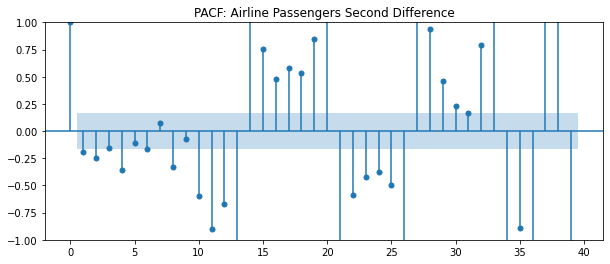

In [85]:
fig, ax = plt.subplots(figsize=(10,4))
title='PACF: Airline Passengers Second Difference'
lags=40
plot_pacf(df['d2'].dropna(),ax=ax,title=title,lags=np.arange(lags));  # be sure to add .dropna() here!

### <font color=blue> 4. Define function for ACF and PACF plot

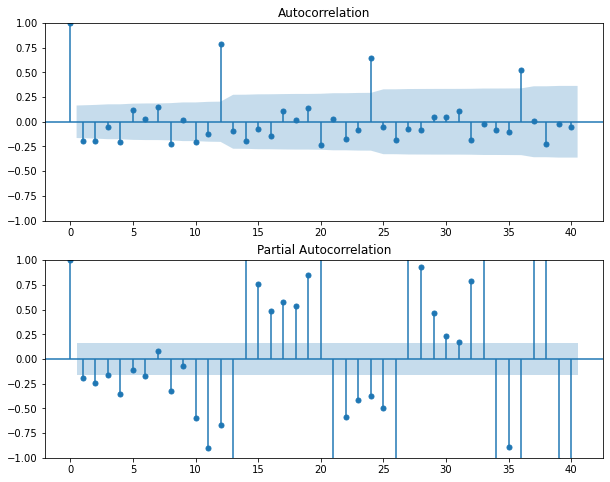

In [86]:
def plot_acf_pacf1(ts):
    fig = plt.figure(figsize=(10,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(ts.squeeze(), lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(ts, lags=40, ax=ax2)
    
plot_acf_pacf1(df['d2'].dropna())

The output plots show a sudden drop at lag 1 for both ACF and PACF, thus poiting toward possible value of p and q to be 1 each, resepectively



In [87]:
def plot_acf_pacf2(data, lag_auto_corr, lag_par_auto_corr):
    plt.figure(figsize=(16,5))
    # ACF
    plt.subplot(121)
    #plt.plot(lag_auto_corr)
    plt.stem(lag_auto_corr)
    plt.axhline(y=0, linestyle = '--', color='black')
    plt.axhline(y=-1.96/np.sqrt(len(data)), linestyle='--', color='black')
    plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--', color='black')
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.title('Autocorrelation Function')
    # PACF
    plt.subplot(122)
    #plt.plot(lag_par_auto_corr)
    plt.stem(lag_par_auto_corr)
    plt.axhline(y=0,linestyle='--', color='black')
    plt.axhline(y=-1.96/np.sqrt(len(data)), linestyle='--', color='black')
    plt.axhline(y=1.96/np.sqrt(len(data)), linestyle='--', color='black')
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    plt.title('Partial Autocorrelation Function')

    plt.tight_layout()

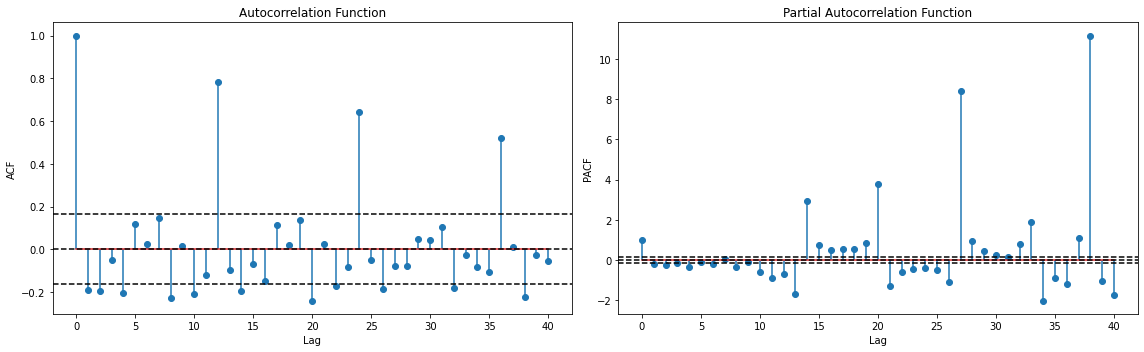

In [88]:
lag_auto_corr = acf(df['d2'].dropna(), nlags=40)
lag_par_auto_corr = pacf(df['d2'].dropna(), nlags=40)

plot_acf_pacf2(df['d2'].dropna(), lag_auto_corr, lag_par_auto_corr)

---
---
# <div class="alert alert-info"> 8. Forecasting </div>

In [89]:
df = df_bk.copy()

## <font color='red'>8.1. Moving Average or MA Modeling


 ### <font color=blue> 1. Simple Moving Average (SMA)

Is a linear regression model that models the impact of noise/error from prior observations to current one. The model is denoted as

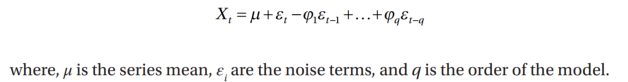

1. We can calcullate SMA by applying a <tt>mean</tt> function to a rolling window.
    + If we use a longer window size, we grab the general trend
    + If we choose a shorter window size, we can then grab the kind of more detailed behavior of that time series, so it can grab a little bit of that seasonality, such asthe orange line for a six month simple moving average
    
2. We could theoretically attempt to use these simple moving averages to build a generalized model for the real world time series we’re analyzing. Just think of it as trying to create a generalized model to describe the general behavior of your time series

In [90]:
df['6-month-SMA'] = df['Thousands of Passengers'].rolling(window=6).mean()
df['12-month-SMA'] = df['Thousands of Passengers'].rolling(window=12).mean()

df.head(15)

,Thousands of Passengers,6-month-SMA,12-month-SMA
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,124.500,NaN
1949-07-01,148,130.500,NaN
1949-08-01,148,135.500,NaN
1949-09-01,136,136.167,NaN


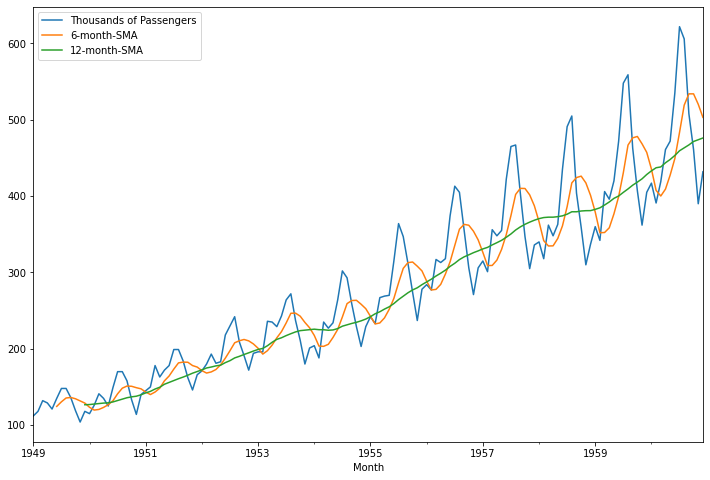

In [91]:
df.plot(figsize=(12,8));

+ Simple moving averages can allow to describe some trend value behavior of a time series. As issue with SMA is that the entire model will be constrained to the same window size. For example, we choose 6-month window size or 12-month window size. We have to use that window for the entire dataset, even if it’s much longer than just 12 months.

+ Smaller windows will lead to more noise, rather than signal. So it’s hard to balance the window size because as you go smaller, you are being more accurate as far as what you’re able to model from that generalized time series. But you start picking up more and more noise. 

+ With SMA, you’re always going to lag by the size of the window. So, it will never reach to full peak or valley of the data due to the averaging. It’s hard to choose a window size that is going to fill up those peaks and valleys for seasonal data, even if you choose very small windows.

+ Does not really inform you about possible future behavior, all it really does is describe trends in your data. 


 ### <font color=blue> 2. Exponentially Weighted Moving Average (EWMA)

To help fix some of these issues, we can use an <a href='https://en.wikipedia.org/wiki/Exponential_smoothing'>EWMA (Exponentially weighted moving average)</a>.

EWMA will allow us to reduce the lag effect from SMA and it will put more weight on values that occured more recently (by applying more weight to the more recent values, thus the name). The amount of weight applied to the most recent values will depend on the actual parameters used in the EWMA and the number of periods given a window size.
[Full details on Mathematics behind this can be found here](http://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows).
Here is the shorter version of the explanation behind EWMA.

The formula for EWMA is:
### $y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i}$

Where $x_t$ is the input value, $w_i$ is the applied weight (Note how it can change from $i=0$ to $t$), and $y_t$ is the output.

Now the question is, how to we define the weight term $w_i$?

This depends on the <tt>adjust</tt> parameter you provide to the <tt>.ewm()</tt> method.

When <tt>adjust=True</tt> (default) is used, weighted averages are calculated using weights equal to $w_i = (1 - \alpha)^i$

which gives

### $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

When <tt>adjust=False</tt> is specified, moving averages are calculated as:

### $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

which is equivalent to using weights:

 \begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

When <tt>adjust=True</tt> we have $y_0=x_0$ and from the last representation above we have 
$y_t=\alpha x_t+(1−α)y_{t−1}$, therefore there is an assumption that $x_0$ is not an ordinary value but rather an exponentially weighted moment of the infinite series up to that point.

For the smoothing factor $\alpha$ one must have $0<\alpha≤1$, and while it is possible to pass <em>alpha</em> directly, it’s often easier to think about either the <em>span</em>, <em>center of mass</em> (com) or <em>half-life</em> of an EW moment:

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}

* <strong>Span</strong> corresponds to what is commonly called an “N-day EW moving average”.
* <strong>Center of mass</strong> has a more physical interpretation and can be thought of in terms of span: $c=(s−1)/2$
* <strong>Half-life</strong> is the period of time for the exponential weight to reduce to one half.
* <strong>Alpha</strong> specifies the smoothing factor directly.

We have to pass precisely one of the above into the <tt>.ewm()</tt> function. For our data we'll use <tt>span=12</tt>.

In [92]:
df['EWMA12'] = df['Thousands of Passengers'].ewm(span=12,adjust=False).mean()

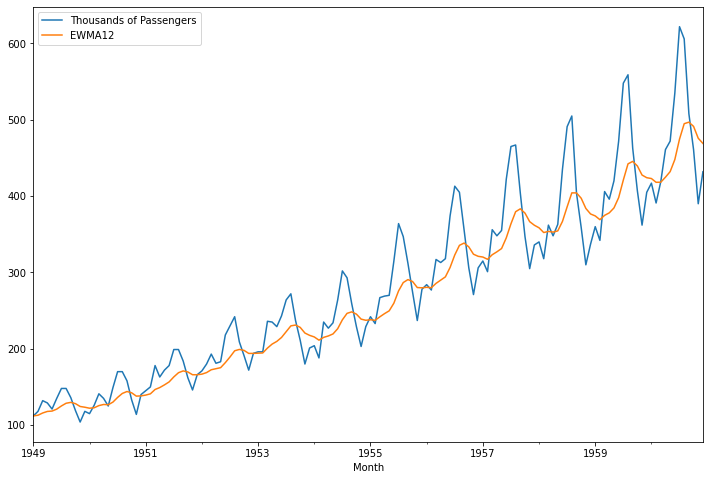

In [93]:
df[['Thousands of Passengers','EWMA12']].plot(figsize=(12,8));

 #### <font color=blue> Comparing SMA to EWMA

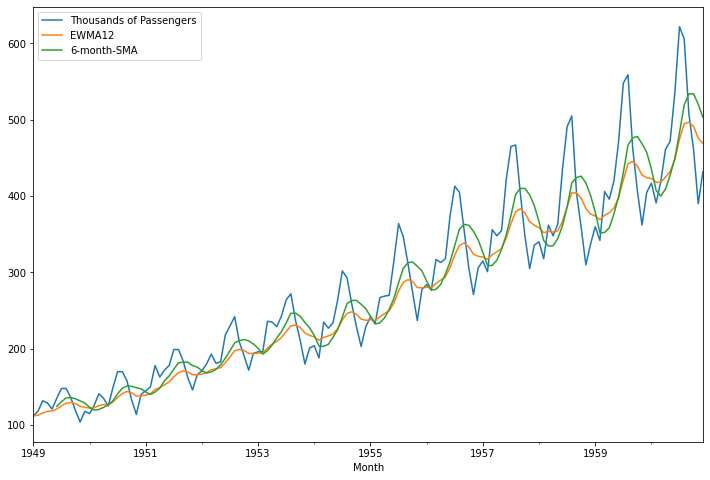

In [94]:
df[['Thousands of Passengers','EWMA12','6-month-SMA']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

**EWMA** and **SMA** using just one smoothing factor $\alpha$ (alpha). This failed to account for other contributing factors like trend and seasonality

 ## <font color=red> 8.2. Holt-Winters Methods
In this section we'll look at <em>Double</em> and <em>Triple Exponential Smoothing</em> with the <a href='https://otexts.com/fpp2/holt-winters.html'>Holt-Winters Methods</a>. 

In <strong>Double Exponential Smoothing</strong> (aka Holt's Method) we introduce a new smoothing factor $\beta$ (beta) that addresses trend:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
y_t &= l_t + b_t & \text{    fitted model}\\
\hat y_{t+h} &= l_t + hb_t & \text{    forecasting model (} h = \text{# periods into the future)}\end{split}

Because we haven't yet considered seasonal fluctuations, the forecasting model is simply a straight sloped line extending from the most recent data point. We'll see an example of this in upcoming lectures.

With <strong>Triple Exponential Smoothing</strong> (aka the Holt-Winters Method) we introduce a smoothing factor $\gamma$ (gamma) that addresses seasonality:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) & \text{    seasonal}\\
y_t &= (l_t + b_t) c_t & \text{    fitted model}\\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} & \text{    forecasting model (} m = \text{# periods into the future)}\end{split}

Here $L$ represents the number of divisions per cycle. In our case looking at monthly data that displays a repeating pattern each year, we would use $L=12$.

In general, higher values for $\alpha$, $\beta$ and $\gamma$ (values closer to 1), place more emphasis on recent data.


In [95]:
df = df_bk.copy()

 ### <font color=blue> 1.  Simple Exponential Smoothing

A variation of the statmodels Holt-Winters function provides Simple Exponential Smoothing. We'll show that it performs the same calculation of the weighted moving average as the pandas <tt>.ewm()</tt> method:<br>
$\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

In [96]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

df['EWMA12'] = df['Thousands of Passengers'].ewm(alpha=alpha,adjust=False).mean()
df['SES12']=SimpleExpSmoothing(df['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,SES12
Month,,,
1949-01-01,112,112.000,112.000
1949-02-01,118,112.923,112.923
1949-03-01,132,115.858,115.858
1949-04-01,129,117.880,117.880
1949-05-01,121,118.360,118.360


<div class="alert alert-danger"><strong>NOTE:</strong> For some reason, when <tt>optimized=False</tt> is passed into <tt>.fit()</tt>, the statsmodels <tt>SimpleExpSmoothing</tt> function shifts fitted values down one row. We fix this by adding <tt>.shift(-1)</tt> after <tt>.fittedvalues</tt></div>

 ### <font color=blue>2. Double Exponential Smoothing
Where Simple Exponential Smoothing employs just one smoothing factor $\alpha$ (alpha), Double Exponential Smoothing adds a second smoothing factor $\beta$ (beta) that addresses trends in the data. Like the alpha factor, values for the beta factor fall between zero and one ($0<\beta≤1$). The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations.

We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an <strong>additive</strong> adjustment. If the time series displays an exponential (curved) trend, you would use a <strong>multiplicative</strong> adjustment.

As we move toward forecasting, it's worth noting that both additive and multiplicative adjustments may become exaggerated over time, and require <em>damping</em> that reduces the size of the trend over future periods until it reaches a flat line.

In [97]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df['DESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='add').fit().fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12
Month,,,,
1949-01-01,112,112.000,112.000,114.102
1949-02-01,118,112.923,112.923,120.041
1949-03-01,132,115.858,115.858,134.002
1949-04-01,129,117.880,117.880,131.086
1949-05-01,121,118.360,118.360,123.110


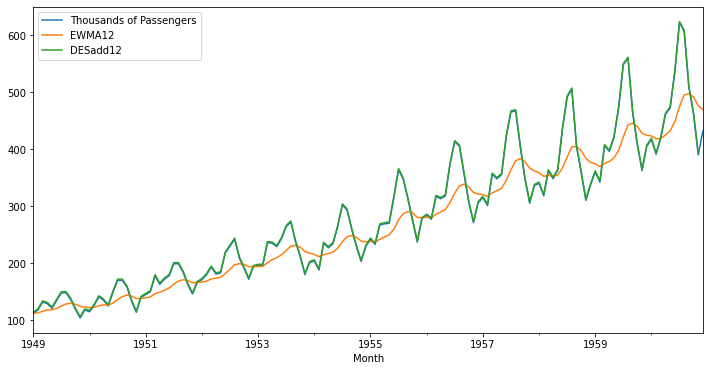

In [98]:
df[['Thousands of Passengers','EWMA12','DESadd12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

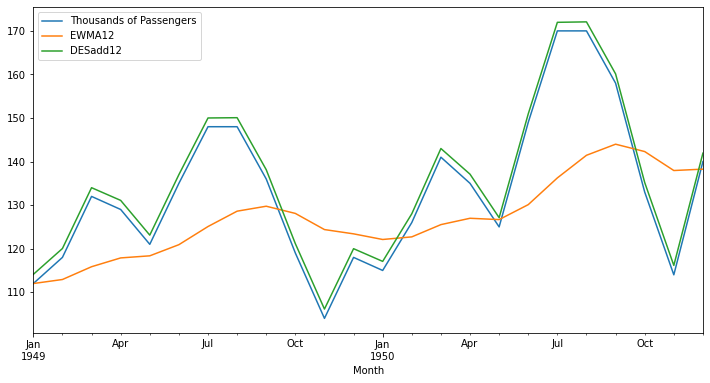

In [99]:
df[['Thousands of Passengers','EWMA12','DESadd12']].iloc[0:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Here we can see that Double Exponential Smoothing is a much better representation of the time series data.<br>
Let's see if using a multiplicative seasonal adjustment helps.

In [100]:
df['DESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12
Month,,,,,
1949-01-01,112,112.000,112.000,114.102,113.991
1949-02-01,118,112.923,112.923,120.041,120.032
1949-03-01,132,115.858,115.858,134.002,134.236
1949-04-01,129,117.880,117.880,131.086,131.271
1949-05-01,121,118.360,118.360,123.110,123.156


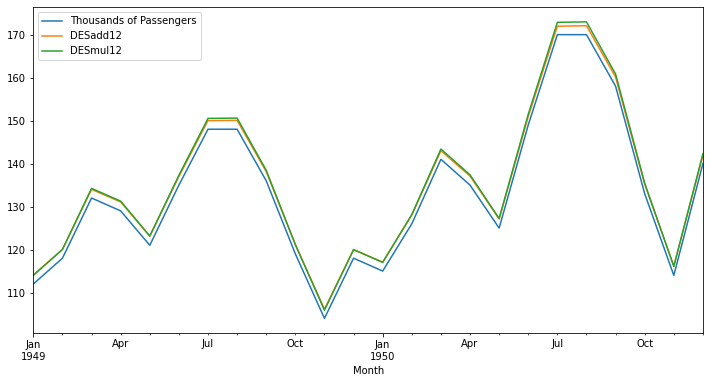

In [101]:
df[['Thousands of Passengers','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Although minor, it does appear that a multiplicative adjustment gives better results. Note that the green line almost completely overlaps the original data.

 ### <font color=blue>3. Triple Exponential Smoothing
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 



In [102]:
df['TESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12,TESadd12
Month,,,,,,
1949-01-01,112,112.000,112.000,114.102,113.991,112.007
1949-02-01,118,112.923,112.923,120.041,120.032,120.149
1949-03-01,132,115.858,115.858,134.002,134.236,134.693
1949-04-01,129,117.880,117.880,131.086,131.271,131.368
1949-05-01,121,118.360,118.360,123.110,123.156,124.625


In [103]:
df['TESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

,Thousands of Passengers,EWMA12,SES12,DESadd12,DESmul12,TESadd12,TESmul12
Month,,,,,,,
1949-01-01,112,112.000,112.000,114.102,113.991,112.007,111.592
1949-02-01,118,112.923,112.923,120.041,120.032,120.149,118.843
1949-03-01,132,115.858,115.858,134.002,134.236,134.693,133.333
1949-04-01,129,117.880,117.880,131.086,131.271,131.368,127.902
1949-05-01,121,118.360,118.360,123.110,123.156,124.625,120.980


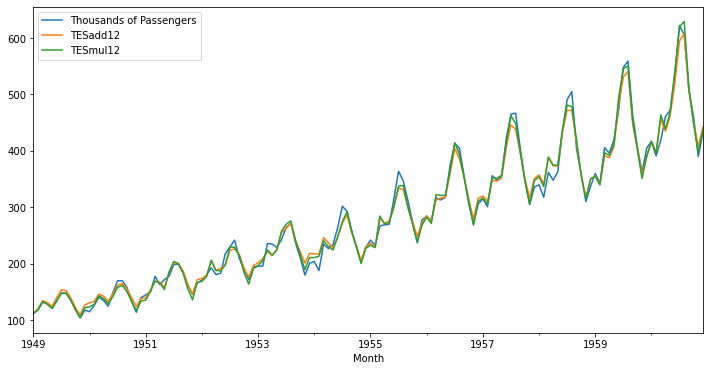

In [104]:
df[['Thousands of Passengers','TESadd12','TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

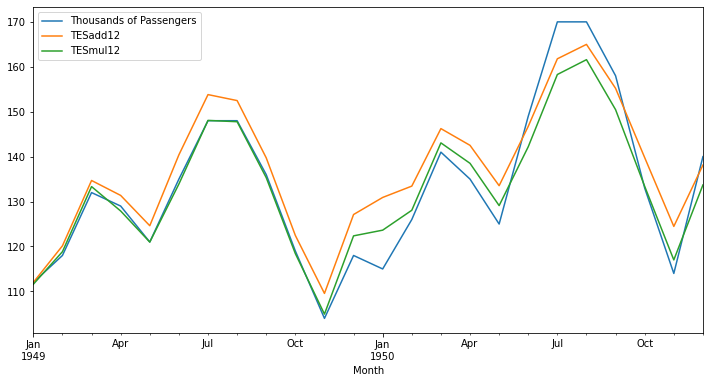

In [105]:
df[['Thousands of Passengers','TESadd12','TESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Based on the plot above, you might think that Triple Exponential Smoothing does a poorer job of fitting than Double Exponential Smoothing. The key here is to consider what comes next - <em>forecasting</em>. We'll see that having the ability to predict fluctuating seasonal patterns greatly improves our forecast.

But first, we'll work out some time series exercises before moving on to forecasting.

 ### <font color=blue>4. Forecasting with the Holt-Winters Method
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 



In [106]:
df = df_bk.copy()

#### Train Test Split

In [107]:
train_data = df.iloc[:108] # Goes up to but not including 108
test_data = df.iloc[108:]

#### Fit the model

In [108]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(train_data['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

#### Evaluating Model against Test Set

In [109]:
# YOU CAN SAFELY IGNORE WARNINGS HERE!
# THIS WILL NOT AFFECT YOUR FORECAST, IT'S JUST SOMETHING STATSMODELS NEEDS TO UPDATE UPON NEXT RELEASE.
test_predictions = fitted_model.forecast(36).rename('HW Forecast')
test_predictions

1958-01-01   356.969
1958-02-01   344.589
1958-03-01   405.718
1958-04-01   400.611
1958-05-01   409.002
1958-06-01   480.694
1958-07-01   530.470
1958-08-01   523.288
1958-09-01   454.210
1958-10-01   392.518
1958-11-01   345.928
1958-12-01   396.605
1959-01-01   408.959
1959-02-01   394.776
1959-03-01   464.809
1959-04-01   458.957
1959-05-01   468.570
1959-06-01   550.704
1959-07-01   607.729
1959-08-01   599.502
1959-09-01   520.363
1959-10-01   449.686
1959-11-01   396.311
1959-12-01   454.368
1960-01-01   468.521
1960-02-01   452.272
1960-03-01   532.505
1960-04-01   525.801
1960-05-01   536.814
1960-06-01   630.911
1960-07-01   696.241
1960-08-01   686.816
1960-09-01   596.151
1960-10-01   515.180
1960-11-01   454.031
1960-12-01   520.544
Freq: MS, Name: HW Forecast, dtype: float64

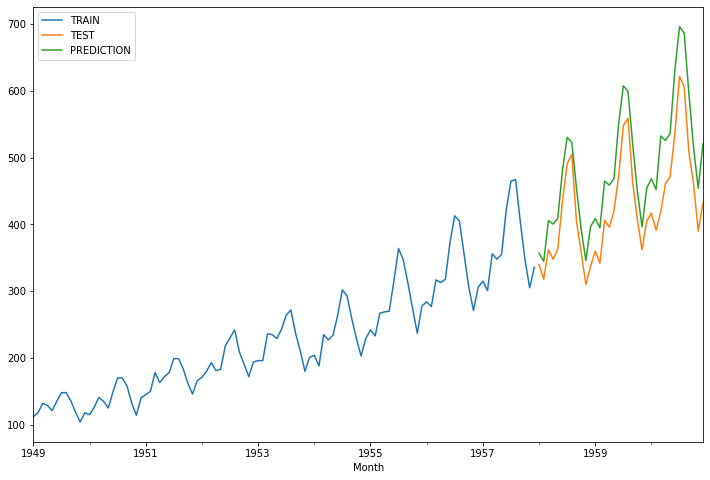

In [110]:
train_data['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_data['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

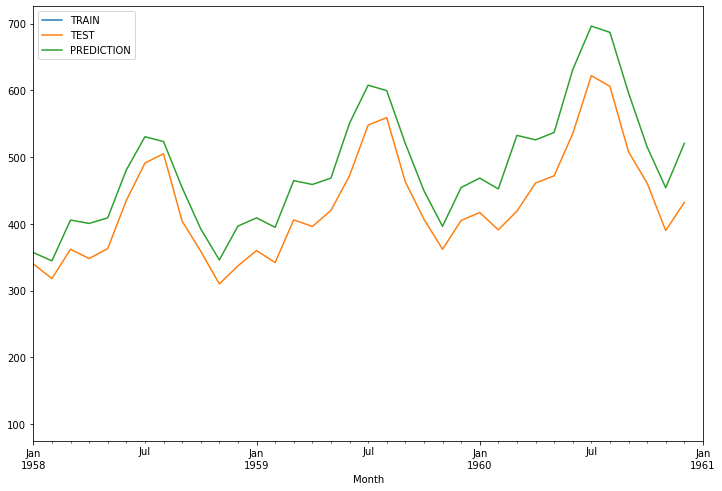

In [111]:
train_data['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_data['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION',xlim=['1958-01-01','1961-01-01']);

#### Evaluation Metrics

In [112]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [113]:
mean_absolute_error(test_data,test_predictions)

55.69782636118518

In [114]:
mean_squared_error(test_data,test_predictions)

3525.867525316523

In [115]:
np.sqrt(mean_squared_error(test_data,test_predictions))

59.37901586685757

In [116]:
test_data.describe()

,Thousands of Passengers
count,36.000
mean,428.500
std,79.329
min,310.000
25%,362.000
50%,412.000
75%,472.000
max,622.000


#### Forecasting into Future

In [117]:
final_model = ExponentialSmoothing(df['Thousands of Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit()

In [118]:
forecast_predictions = final_model.forecast(36)

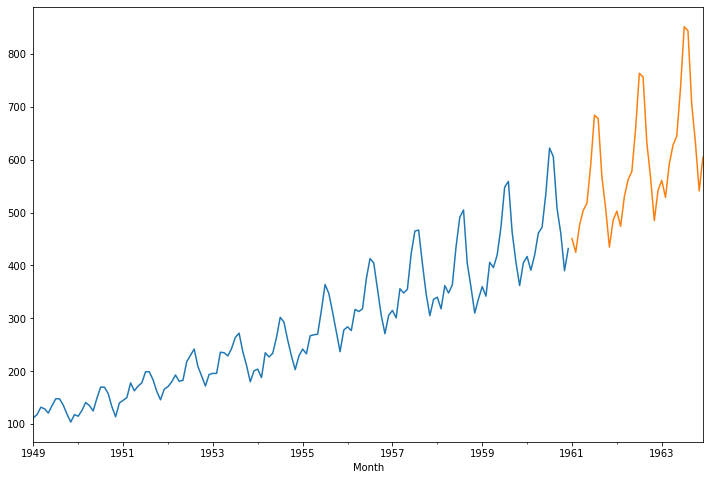

In [119]:
df['Thousands of Passengers'].plot(figsize=(12,8))
forecast_predictions.plot();

## <font color=red> 8.3. Autoregressive Model - AR(p)

In an autoregression model, we forecast using a linear combination of <em>past values</em> of the variable. The term <em>autoregression</em> describes a regression of the variable against itself. An autoregression is run against a set of <em>lagged values</em> of order $p$.

### $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.

For example, an <strong>AR(1)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

whereas an <strong>AR(2)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \varepsilon_{t}$

and so on.

Note that the lag coeffients are usually less than one, as we usually restrict autoregressive models to stationary data.<br>
Specifically, for an <strong>AR(1)</strong> model: $-1 \lt \phi_1 \lt 1$<br>
and for an <strong>AR(2)</strong> model: $-1 \lt \phi_2 \lt 1, \ \phi_1 + \phi_2 \lt 1, \ \phi_2 - \phi_1 \lt 1$<br>

Models <strong>AR(3)</strong> and higher become mathematically very complex. Fortunately statsmodels does all the heavy lifting for us.

### <font color=blue> 1. Split the data into train/test sets
The goal in this section is to:
* Split known data into a training set of records on which to fit the model
* Use the remaining records for testing, to evaluate the model
* Fit the model again on the <em>full</em> set of records
* Predict a future set of values using the model

As a general rule you should set the length of your test set equal to your intended forecast size. That is, for a monthly dataset you might want to forecast out one more year. Therefore your test set should be one year long.

In [120]:
print(len(df))

# Set one year for testing
train = df.iloc[:120]
test = df.iloc[120:]

144


### <font color=blue> 2. Fit AR(1) Model

#### Train model

In [121]:
# Load specific forecasting tools
from statsmodels.tsa.ar_model import AutoReg,ARResults

model = AutoReg(train['Thousands of Passengers'], lags=1)
AR1fit = model.fit()
print(f'Coefficients:\n{AR1fit.params}')

Coefficients:
const                        14.264
Thousands of Passengers.L1    0.950
dtype: float64


#### Prediction

In [122]:
# This is the general format for obtaining predictions
start=len(train)
end=len(train)+len(test)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')
predictions1

1959-01-01   334.254
1959-02-01   331.647
1959-03-01   329.172
1959-04-01   326.821
1959-05-01   324.589
1959-06-01   322.470
1959-07-01   320.458
1959-08-01   318.547
1959-09-01   316.733
1959-10-01   315.010
1959-11-01   313.374
1959-12-01   311.821
1960-01-01   310.346
1960-02-01   308.946
1960-03-01   307.616
1960-04-01   306.354
1960-05-01   305.155
1960-06-01   304.016
1960-07-01   302.935
1960-08-01   301.909
1960-09-01   300.935
1960-10-01   300.009
1960-11-01   299.131
1960-12-01   298.296
Freq: MS, Name: AR(1) Predictions, dtype: float64

In [123]:
# Comparing predictions to expected values
for i in range(len(predictions1)):
    print(f"predicted={predictions1[i]}, expected={test['Thousands of Passengers'][i]}")

predicted=334.25429528565525, expected=360
predicted=331.647179171782, expected=342
predicted=329.1716564414219, expected=406
predicted=326.8210849590396, expected=396
predicted=324.589157848847, expected=420
predicted=322.4698865726703, expected=472
predicted=320.45758486195723, expected=548
predicted=318.54685346081067, expected=559
predicted=316.73256563911326, expected=463
predicted=315.0098534368727, expected=407
predicted=313.374094602879, expected=362
predicted=311.8209001926297, expected=405
predicted=310.34610279224535, expected=417
predicted=308.9457453367795, expected=391
predicted=307.61607049292115, expected=419
predicted=306.3535105776018, expected=461
predicted=305.15467798545797, expected=472
predicted=304.0163560994643, expected=535
predicted=302.93549066034996, expected=622
predicted=301.9091815716408, expected=606
predicted=300.9346751183396, expected=508
predicted=300.00935657836646, expected=461
predicted=299.1307432069336, expected=390
predicted=298.29647757503227

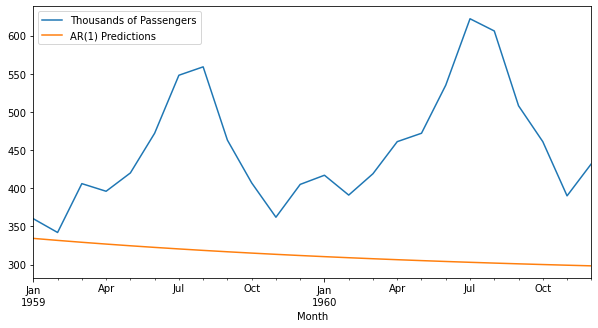

In [124]:
test['Thousands of Passengers'].plot(legend=True)
predictions1.plot(legend=True,figsize=(10,5));

### <font color=blue> 3. Fit an AR(2) Model

In [125]:
model = AutoReg(train['Thousands of Passengers'], lags=2)
AR2fit = model.fit()
print(f'Coefficients:\n{AR2fit.params}')

Coefficients:
const                        16.914
Thousands of Passengers.L1    1.249
Thousands of Passengers.L2   -0.313
dtype: float64


In [126]:
start=len(train)
end=len(train)+len(test)-1
predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

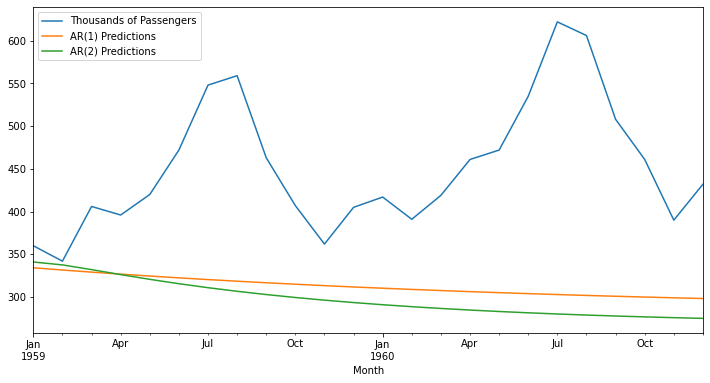

In [127]:
test['Thousands of Passengers'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True,figsize=(12,6));

### <font color=blue> 4. Fit an AR(p) Model where statsmodels chooses p


In [128]:
model = AutoReg(train['Thousands of Passengers'],lags=12)
ARfit = model.fit()
print(f'Coefficients:\n{ARfit.params}')

Coefficients:
const                         13.805
Thousands of Passengers.L1     0.510
Thousands of Passengers.L2    -0.297
Thousands of Passengers.L3     0.226
Thousands of Passengers.L4    -0.294
Thousands of Passengers.L5     0.323
Thousands of Passengers.L6    -0.279
Thousands of Passengers.L7     0.275
Thousands of Passengers.L8    -0.360
Thousands of Passengers.L9     0.299
Thousands of Passengers.L10   -0.279
Thousands of Passengers.L11    0.369
Thousands of Passengers.L12    0.534
dtype: float64


In [129]:
start = len(train)
end = len(train)+len(test)-1
rename = f'AR(12) Predictions'

predictions12 = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)

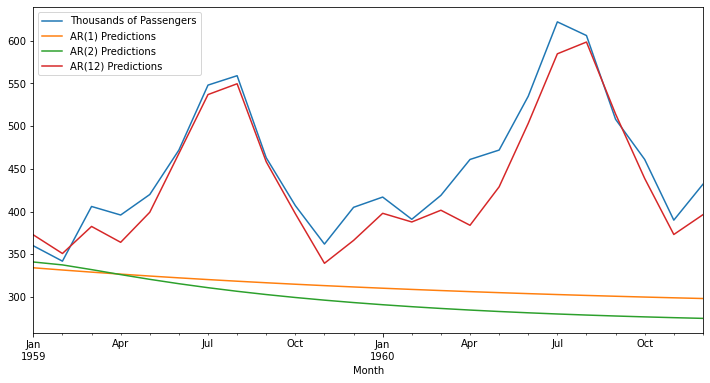

In [130]:
test['Thousands of Passengers'].plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions12.plot(legend=True,figsize=(12,6));

### <font color=blue> 5. Evaluate the Model
    
It helps to have a means of comparison between two or more models. One common method is to compute the Mean Squared Error (MSE), available from scikit-learn.

In [131]:
from sklearn.metrics import mean_squared_error

labels = ['AR(1)','AR(2)','AR(12)']
preds = [predictions1, predictions2, predictions12]  # these are variables, not strings!

for i in range(3):
    error = mean_squared_error(test['Thousands of Passengers'], preds[i])
    print(f'{labels[i]} Error: {error:11.10}')

AR(1) Error: 25759.96727
AR(2) Error: 30911.62376
AR(12) Error: 732.9665004


We see right away how well AR(11) outperformed the other two models.

Another method is the <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike information criterion</a> (AIC), which does a better job of evaluating models by avoiding overfitting.<br>
Fortunately this is available directly from the fit model object.

In [132]:
modls = [AR1fit,AR2fit,ARfit]

for i in range(3):
    print(f'{labels[i]} AIC: {modls[i].aic:6.5}')

AR(1) AIC: 1138.9
AR(2) AIC: 1120.2
AR(12) AIC: 886.25


### <font color=blue> 6. Forecasting

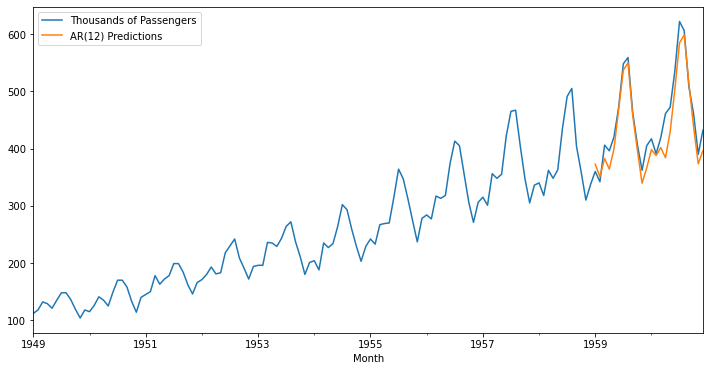

In [133]:
# Forcast
fc = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)

# Plot the results
df['Thousands of Passengers'].plot(legend=True)
fc.plot(legend=True,figsize=(12,6));